In [1]:
import nltk
import re
import itertools
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

import spacy
from spacy import displacy
nlp = spacy.blank('en')

import gc
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup, AdamW
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from seqeval.metrics import classification_report as classification_report_seqeval


import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/helloworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_23674/1960782155.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/helloworld/DRDO DEBEL/BioNER/CORD19/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-25 20:55:21.823939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable 

In [2]:
# Clear CUDA cache
torch.cuda.empty_cache()
# Run garbage collector
gc.collect()

0

In [ ]:
# Get the name of the GPU device (if available)
device_name = tf.test.gpu_device_name()

# Check if the device name matches the default name for the first GPU device
if device_name == '/device:GPU:0':
    # If a GPU is found, print a message indicating its presence
    print('Found GPU at: {}'.format(device_name))
else:
    # If no GPU is found, raise a SystemError with an appropriate message
    raise SystemError('GPU device not found')

In [4]:
# Check if CUDA is available, if yes, set device to CUDA, otherwise to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

In [5]:
# Define the maximum length for tokenization
MAX_LEN = 100
# Define the batch size for processing
BATCH_SIZE = 16
# Create a BERT tokenizer instance
tokenizer = BertTokenizer(vocab_file='input/biobert-v11-pubmed/vocab.txt', do_lower_case=False)

<h1><strong>Loading Dataset</strong></h1>


In [6]:
#reads a CSV file into a Pandas DataFrame
data=pd.read_csv('input/cord19processeddataset/ner_covid_final_data_v3.csv')
#fill any missing values in the DataFrame with the string '0'
data.fillna('0',inplace=True)
#removes a column named "Unnamed: 0" from the DataFrame
data.drop(columns=["Unnamed: 0"],inplace=True)
#creates a list called drop_tags_less_than_10000 containing tags (from column '1') that have less than 10,000 occurrences in the data
drop_tags_less_than_10000=list(data['1'].value_counts()[data['1'].value_counts() < 10000].index)

#store indices to drop
index_to_drop=[]
for i in drop_tags_less_than_10000:
    #finds the indices in the DataFrame where the 'Tag' column matches that tag
    index_to_drop.extend(data[ data['1'] == i ].index) 
#drop the rows corresponding to tags with fewer than 10,000 occurrences   
data.drop(index_to_drop, inplace = True)

data.rename(columns={"0": "Word", "1": "Tag","2":"Sentence #"},inplace=True)
#drops 90% rows where the tag is "Other"
data.drop(data.query('Tag == "Other"').sample(frac=.9).index, inplace = True)

tag_values = data['Tag'].values
print("tag_values",tag_values)
vocab_len = len(tag_values)
print('Entity Types:',vocab_len)

/tmp/ipykernel_23674/2315072740.py:2: DtypeWarning: Columns (4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('input/cord19processeddataset/ner_covid_final_data_v3.csv')
/tmp/ipykernel_23674/2315072740.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.fillna('0',inplace=True)


tag_values ['B-GENE_OR_GENOME' 'I-GENE_OR_GENOME' 'I-GENE_OR_GENOME' ...
 'I-GENE_OR_GENOME' 'B-CHEMICAL' 'Other']
Entity Types: 218082


<h2><strong>Discover and Visualize the Data to Gain Insights</strong></h2>

In [7]:
data_tags = data[['Tag']]
data_tags.head(10)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder() # create one binary attribute per category
data_tags_1hot = cat_encoder.fit_transform(data_tags)
data_tags_array = data_tags_1hot.toarray() # Returns a sparse matrix thus converting it to array 
categories = cat_encoder.categories_[0]
category_frequencies = data_tags_array.sum(axis=0)

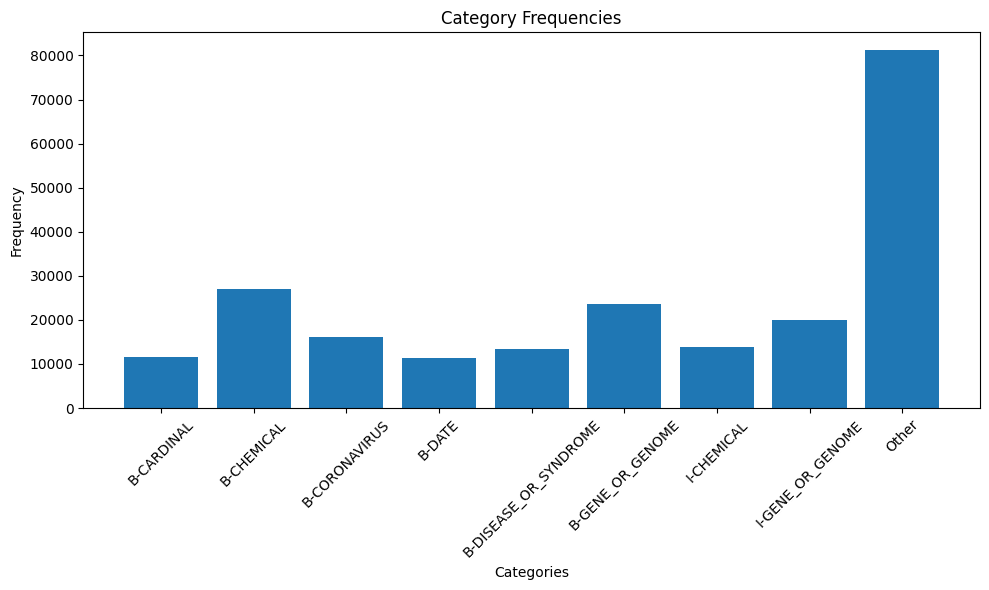

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories, category_frequencies)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Category Frequencies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [9]:
"""The GetSentence class is processing text data into sentences with their corresponding words and tags."""
class GetSentence(object):
    def __init__(self,data):
        self.data = data
        self.n_sentences = 1
        self.empty = False
        #Creating a function that creates a list of tuple containing (Word,Tags) 
        agg_function = lambda s: [(w,t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        #Group the data by "Sentence #" and apply the agg_function to create sentence groups
        self.group = self.data.groupby('Sentence #').apply(agg_function)
        # self.sentence is now a list of sentences, where each sentence is represented as a list of tuples
        self.sentence = [s for s in self.group]

getter = GetSentence(data)


/tmp/ipykernel_23674/804463311.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.group = self.data.groupby('Sentence #').apply(agg_function)


In [10]:
# Extract tags from each sentence
tag1 = [[word[1] for word in sentence] for sentence in getter.sentence]
# print("tag1",tag1)
# Extract words from each sentence
sentences1 = [[word[0] for word in sentence] for sentence in getter.sentence]

# Assign the extracted sentences and tags to variables for further processing
tags = tag1
sentences = sentences1

print(sentences[0])
print(tags[0])

['angiotensin-converting', 'enzyme', '2', 'ace2', 'sars-cov-2', 'receptor', 'potential', 'sars-cov-2', 'has', 'sars-cov-2', 'there', 'sars-cov-2', 'not', 'sars-cov-2', 'sars', 'cov', 'spike', 'proteins', 'sars-cov-2', 'sars', 'cov', 'sars-cov', 'spike', 'protein', 'binding', 'crystal', 'structure', 'analysis', '[7', 'sars-cov-2', 'sars', 'cov', '76', 'identity', 'amino']
['B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-CORONAVIRUS', 'B-CHEMICAL', 'Other', 'B-CORONAVIRUS', 'Other', 'B-CORONAVIRUS', 'Other', 'B-CORONAVIRUS', 'Other', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CHEMICAL', 'I-CHEMICAL', 'I-CHEMICAL', 'B-DISEASE_OR_SYNDROME', 'B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-DATE', 'B-DISEASE_OR_SYNDROME', 'B-CHEMICAL']


<h2><strong>Data Cleaning And Tokenization</strong></h2>


In [11]:
#Function to tokenize words in a sentence along with their labels
def tok_with_labels(sent, text_labels):
    tok_sent = [] # store tokenized words
    labels = [] # store labels.
    # Iterate through each word in the sentence and its corresponding label
    for word, label in zip(sent, text_labels):
        tok_word = tokenizer.tokenize(word) # Tokenize the current word using a tokenizer
        n_subwords = len(tok_word) # Calculate the number of subwords produced by tokenization

        tok_sent.extend(tok_word) # Extend the lists with tokenized words and corresponding labels
        labels.extend([label] * n_subwords)
    return tok_sent, labels


# Calling the tok_with_labels function to each sentence and its corresponding tags
tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]
print(tok_texts_and_labels[0]) 
#(['an', '##gio', '##tens', '##in', ...],['B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME',...]

(['an', '##gio', '##tens', '##in', '-', 'converting', 'enzyme', '2', 'ace', '##2', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'receptor', 'potential', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'has', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'there', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'not', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'spike', 'proteins', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'sa', '##rs', '-', 'co', '##v', 'spike', 'protein', 'binding', 'crystal', 'structure', 'analysis', '[', '7', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', '76', 'identity', 'amino'], ['B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CHEMICAL', 'O

In [12]:
#extracts the tokenized texts from the tok_texts_and_labels list of tuples
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
print(tok_texts[0])
#extracts the corresponding labels from the tok_texts_and_labels
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]
print(labels[0])

['an', '##gio', '##tens', '##in', '-', 'converting', 'enzyme', '2', 'ace', '##2', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'receptor', 'potential', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'has', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'there', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'not', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'spike', 'proteins', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'sa', '##rs', '-', 'co', '##v', 'spike', 'protein', 'binding', 'crystal', 'structure', 'analysis', '[', '7', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', '76', 'identity', 'amino']
['B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-GENE_OR_GENOME', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CORONAVIRUS', 'B-CHEMICAL', 'Oth

In [13]:
#tokenizes the texts using the convert_tokens_to_ids method and then pads the sequences to a maximum length (MAX_LEN = 100)
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [14]:
for char in tok_texts:
    print('WordPiece Tokenizer Preview:\n', char)
    break

WordPiece Tokenizer Preview:
 ['an', '##gio', '##tens', '##in', '-', 'converting', 'enzyme', '2', 'ace', '##2', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'receptor', 'potential', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'has', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'there', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'not', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'spike', 'proteins', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', 'sa', '##rs', '-', 'co', '##v', 'spike', 'protein', 'binding', 'crystal', 'structure', 'analysis', '[', '7', 'sa', '##rs', '-', 'co', '##v', '-', '2', 'sa', '##rs', 'co', '##v', '76', 'identity', 'amino']


In [15]:
#creating a mapping from unique tags to indices
tag_values = list(set(itertools.chain.from_iterable(tags))) # This part takes a lists (tags), flattens it into a single unique list
tag_values.append("PAD") #checking padding

#creates a dictionary where the keys are the unique tags, and the values are the corresponding indices
tag2idx = {t: i for i,t in enumerate(tag_values)} 
print('Tag indices',tag2idx)

Tag indices {'I-GENE_OR_GENOME': 0, 'B-CARDINAL': 1, 'Other': 2, 'B-DISEASE_OR_SYNDROME': 3, 'B-CHEMICAL': 4, 'B-DATE': 5, 'I-CHEMICAL': 6, 'B-CORONAVIRUS': 7, 'B-GENE_OR_GENOME': 8, 'PAD': 9}


In [16]:
"""The code takes a list of sequences of tags (labels), converts them to sequences of tag indices using a dictionary (tag2idx), and then pads these sequences to a maximum length (MAX_LEN)"""
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

**The code generates attention masks for a list of tokenized input sequences (input_ids). The resulting attention_masks list contains lists of float values,where attention_mask value of 1.0 if the token is not a padding token (i != 0.0 is True), and 0.0 if it is a padding token (i != 0.0 is False)**

In [17]:
# Create attention masks for the input_ids
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

**Splits the input data (input_ids and tags) into training and validation sets.Similarly split the corresponding attention masks (attention_masks) into training and validation sets.
Converts the resulting training and validation sets into PyTorch tensors for use in PyTorch models.**

In [18]:
# Split the data into training and validation sets for input_ids and tags
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,random_state=2022, test_size=0.18)
# Split the attention mask into training and validation sets 
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2022, test_size=0.18)

# Convert the data to PyTorch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

**this code prepares the training and validation data for training the model. It uses TensorDataset to create datasets from input tensors, RandomSampler for shuffling training data, SequentialSampler for sequential sampling of validation data, and DataLoader to create iterators for efficient loading of batches during training and validation**

In [19]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags) # Create TensorDataset for training data
train_sampler = RandomSampler(train_data) # Create a sampler for training data to shuffle the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE) # Create a DataLoader for managing batches, shuffling, and parallel loading of training data

valid_data = TensorDataset(val_inputs, val_masks, val_tags)# Create TensorDataset for validation data
valid_sampler = SequentialSampler(valid_data)# Create a sampler for validation data to go through the data sequentially
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)# Similar to the training DataLoader, but for the validation set

**The code loads a BERT configuration from a JSON file (bert_config.json).
It then loads pre-trained BERT model weights from a binary file (pytorch_model.bin).
Next, it adapts the keys of the pre-trained model's to match the internal structure of BERT.
Finally, it stores the adapted keys and their corresponding values in an OrderedDict named state_dict.**

In [20]:
# Load the BERT configuration from a JSON file
config = BertConfig.from_json_file('input/biobert-v11-pubmed/bert_config.json')

# Load the pre-trained BERT model weights
tmp_d = torch.load('pytorch_model.bin', map_location=device)

# Create an OrderedDict for the adapted state_dict
state_dict = OrderedDict()

# Iterate through the keys of the pre-trained model's state_dict
for i in list(tmp_d.keys())[:199]:
    x = i
    # If the key contains 'bert', modify it to match BERT's internal structure
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    # Store the modified key and its corresponding value in the adapted state_dict
    state_dict[x] = tmp_d[i]

In [21]:
#The BioBertNER class defines a PyTorch neural network module for NER tasks using a BioBERT model
class BioBertNER(nn.Module):
    def __init__(self, vocab_len, config, state_dict):
        super().__init__()
        self.bert = BertModel(config)
        self.bert.load_state_dict(state_dict, strict=False)
        self.dropout = nn.Dropout(p=0.10)
        self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        encl = encoded_layer[-1]
        out = self.dropout(encl)
        out = self.output(out)
        return out, out.argmax(-1)


In [22]:
model = BioBertNER(vocab_len,config,state_dict)
model.load_state_dict(torch.load("BIONER_classifier.pt"))
model.eval()
# model.to(device)

BioBertNER(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


**setting up the optimizer, scheduler, and loss function for training the BioBertNER model**

In [23]:
#Retrieves the named parameters of the model.
param_optimizer = list(model.named_parameters()) 
#Specifies which parameters should not have weight decay
no_decay = ['bias', 'gamma', 'beta']
#Divides the parameters into two groups:
#Parameters with weight decay ('weight_decay_rate': 0.01) for regular training.
#Parameters without weight decay ('weight_decay_rate': 0.0) for parameters like bias, gamma, and beta
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
#Create an AdamW optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5, #Learning rate
    eps=1e-8 #Epsilon value
)

epochs = 20 #Number of training epochs (set to 20)
max_grad_norm = 1.0 #Maximum gradient norm to prevent exploding gradients

total_steps = len(train_dataloader) * epochs #Total number of training steps (batches * epochs)

#Creates a linear scheduler with warm-up
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
#Uses the Cross Entropy Loss function for training and moves the computation to the specified device
loss_fn = nn.CrossEntropyLoss().to(device)

/home/helloworld/DRDO DEBEL/BioNER/CORD19/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<h2><b>Model Training</b></h2>

In [24]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train() # Sets the model to training mode
    losses = [] # List to store batch losses
    correct_predictions = 0 # Counter for correct predictions

    #Iterating Through Batches
    for step,batch in tqdm(enumerate(data_loader)):
        batch = tuple(t.to(device).long() for t in batch) # Move batch to device
        b_input_ids, b_input_mask, b_labels = batch  # Unpack the batch
        outputs,y_hat = model(b_input_ids,b_input_mask) #compute predicted outputs by passing inputs to the model

        # Calculate predicted classes
        _,preds = torch.max(outputs,dim=2) 

        # Reshape outputs and labels for loss calculation
        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)

        # Calculate the loss
        loss = loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)  # Count correct predictions 
        losses.append(loss.item()) # Store the loss

        #compute gradient of the loss with respect to model parameters
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update weights
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return correct_predictions.double()/len(data_loader) , np.mean(losses)

In [25]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval() # Sets the model to evaluation mode
    losses = [] # List to store batch losses
    correct_predictions = 0 # Counter for correct predictions
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader): # Iterate through data loader
            batch = tuple(t.to(device).long() for t in batch) # Move batch to device
            b_input_ids, b_input_mask, b_labels = batch # Unpack the batch

            # compute predicted outputs by passing inputs to the model
            outputs,y_hat = model(b_input_ids,b_input_mask)
            # Calculate predicted classes
            _,preds = torch.max(outputs,dim=2)
            # Reshape outputs and labels for loss calculation
            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            # Calculate the loss
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())
        
    # Calculate accuracy and average loss for the evaluation
    return correct_predictions.double()/len(data_loader) , np.mean(losses)


**the main training loop where the model is trained for multiple epochs on the training dataset, while evaluating its performance on a validation set after each epoch**

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
normalizer = BATCH_SIZE*MAX_LEN
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    # Training the model for one epoch
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    train_acc = train_acc/normalizer
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader)  
    loss_values.append(avg_train_loss)

     # Evaluating the model on the validation set
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    val_acc = val_acc/normalizer
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    # Storing metrics in history dictionary
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

<h2><b>Text preprocessing</b></h2>

In [26]:
text = """In addition to their essential catalytic role in protein biosynthesis, aminoacyl tRNA synthetases participate into numerous other functions, including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein, we describe a class of aminoacyl tRNA synthetase like HisZ proteins based on the catalytic core of the contemporary class II histidyl tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase (HisG). Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics, a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy, and three other lines of evidence support the direct involvement of HisZ in the transferase function. 1) Genetic experiments demonstrate that complementation of an in-frame deletion of HisG from Escherichia coli (which does not possess HisZ) requires both HisG and HisZ from L. lactis. 2) Coelution of HisG and HisZ during affinity chromatography provides evidence of direct physical interaction. 3) Both HisG and HisZ are required for catalysis of the ATP phosphoribosyltransferase reaction. This observation of a common protein domain linking amino acid biosynthesis and protein synthesis implies an early connection between the biosynthesis of amino acids and proteins."""
# Corrected regular expression to remove Twitter handles, URLs, and special characters
text = re.sub(r"(@\[A-Za-z0-9]+)|([^.0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
# text = re.sub(r"(@[A-Za-z0-9_]+)|([^a-zA-Z0-9\s])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

print(text)

In addition to their essential catalytic role in protein biosynthesis aminoacyl tRNA synthetases participate into numerous other functions including regulation of gene expression and amino acid biosynthesis via transamidation pathways. Herein we describe a class of aminoacyl tRNA synthetase like HisZ proteins based on the catalytic core of the contemporary class II histidyl tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase HisG. Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide. HisZ is required for histidine prototrophy and three other lines of evidence support the direct involvement of HisZ in the transferase function. 1 Genetic experiments demonstrate that complementation of an in

In [27]:
nltk.download('punkt')
# Tokenize the cleaned text into sentences
sent_text = nltk.sent_tokenize(text)


[nltk_data] Downloading package punkt to /home/helloworld/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
sent_text1=[]
for i in sent_text:
    # Further clean each sentence and store in sent_text1 list
    sent_text1.append(re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", i))
    
sent_text1

['In addition to their essential catalytic role in protein biosynthesis aminoacyl tRNA synthetases participate into numerous other functions including regulation of gene expression and amino acid biosynthesis via transamidation pathways',
 'Herein we describe a class of aminoacyl tRNA synthetase like HisZ proteins based on the catalytic core of the contemporary class II histidyl tRNA synthetase whose members lack aminoacylation activity but are instead essential components of the first enzyme in histidine biosynthesis ATP phosphoribosyltransferase HisG',
 'Prediction of the function of HisZ in Lactococcus lactis was assisted by comparative genomics a technique that revealed a link between the presence or the absence of HisZ and a systematic variation in the length of the HisG polypeptide',
 'HisZ is required for histidine prototrophy and three other lines of evidence support the direct involvement of HisZ in the transferase function',
 '1 Genetic experiments demonstrate that complement

In [29]:
tokenized_text = []
for sentence in sent_text1:
    # Tokenize each cleaned sentence into words
    tokenized_text.append(nltk.word_tokenize(sentence))

In [30]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []  # Initialize an empty list to store tokenized words
    # Iterate through each word in the sentence
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word) # Tokenize the word
        tokenized_sentence.extend(tokenized_word) 
        
    # Return the tokenized sentence 
    # print(tokenized_sentence)
    return tokenized_sentence


**This code takes a list of tokenized sentences (tokenized_text), tokenizes each sentence while preserving the original words, converts the tokenized words to their corresponding token IDs, and creates attention masks for each tokenized sentence**

In [31]:
#iterate through each tokenized sentence (sent) in the tokenized_text list and call the tokenize_and_preserve()
tok_texts = [tokenize_and_preserve(sent) for sent in tokenized_text]
# Convert tokenized words to their corresponding token IDs
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
# Create attention masks for each tokenized sentence
input_attentions = [[1]*len(in_id) for in_id in input_ids]

In [32]:
# Convert token IDs of a specific sentence to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[1]) 
# Initialize lists to store processed tokens and their labels
new_tokens, new_labels = [], []
for token in tokens:
    # If the token starts with "##", it's a continuation of the previous subword token
    # Combine it with the previous token by removing the "##" prefix
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        # If it's not a subword token, simply append it to the list
        new_tokens.append(token)

**This code processes the model's predictions (y_hat) for each tokenized input sentence (input_ids) and its corresponding attention masks (input_attentions)**

In [33]:
# Initialize lists to store actual sentences and predicted labels
actual_sentences = []
pred_labels = []
# Iterate through each pair of input_ids and input_attentions
for x,y in zip(input_ids,input_attentions):
     # Convert input_ids and input_attentions to PyTorch tensors
    x = torch.tensor(x)
    y = torch.tensor(y)

    # Reshape input tensors to a suitable format
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])

    # Use the model to make predictions on the input
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy() # Convert predicted label indices to numpy array

    # Convert input IDs back to tokens
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    # Initialize lists to store processed tokens and predicted labels
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        # If token starts with "##", merge it with the previous token
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            # Otherwise, append the token and its predicted label
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)

    # Store the processed tokens and predicted labels for the current sentence
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

**This code combines the processed tokens (actual_sentences) and their corresponding predicted labels (pred_labels) into a flat list format**

In [34]:
# Initialize empty lists to store tokens and their corresponding labels
sent = []
tags = []

# Iterate through each pair of actual_sentences and pred_labels
for token, label in zip(actual_sentences, pred_labels):
    # Iterate through each token and its corresponding label
    for t, l in zip(token, label):
        # Append the token to the 'sent' list
        sent.append(t)
        # Append the corresponding label to the 'tags' list
        tags.append(l)


**This code processes the sent (list of tokens) and their corresponding tags (predicted labels) to create a list of dictionaries where each dictionary represents a word along with its start index, end index, label, and the word itself**

In [35]:
# Initialize variables and lists
lst=[]
total_words=[]
temp=0
test_sentence=' '.join(sent)
# Iterate through each token and its index
for key,i in enumerate(sent):
    # If the token is new
    if i not in total_words: 
        re_string = r"\b({})\b".format(i)
        start=re.search(re_string, test_sentence).start()
        end=re.search(re_string, test_sentence).end()
        # Create dictionary for the word
        dict1={}
        dict1["start"]=start+temp
        dict1["end"]=end
        dict1["label"]=tags[key]
        dict1["Word"]=i
        # Add word to 'total_words' list
        total_words.append(i)
        # Append dictionary to 'lst'
        lst.append(dict1)
        
    else:
        # If the token is a duplicate
        start=start+len(sent[key-1])
        end=end+len(i)+1
        # Create dictionary for the word (indicating duplicate )
        dict1={}
        dict1["start"]=start
        dict1["end"]=end
        dict1["label"]=tags[key]+'2'
        dict1["Word"]=i
        # Add word to 'total_words' list
        total_words.append(i)
        # Append dictionary to 'lst'
        lst.append(dict1)

**This code prepares the data in a format suitable for rendering named entity recognition (NER) visualizations using spaCy's displacy library**

In [246]:
ex = [{"text": test_sentence,
       "ents": lst,
       "title": None}]
cols = {'B-CARDINAL': '#dad1f6','B-CHEMICAL': '#f9d5de','B-DISEASE_OR_SYNDROME': '#adcfad','B-GENE_OR_GENOME': '#fbbf9a',\
        'I-CHEMICAL': '#bdf2fa','I-GENE_OR_GENOME': '#eea69e','Other': "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": cols,}

html = displacy.render(ex, style="ent",options=options, manual=True)
